# Creating plots to illustrate cell fate

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import btrack
import napari
import numpy as np
from tqdm.auto import tqdm
from macrohet import dataio, tile, tools, animate

In [2]:
scale = 6048/1200

## Load data

Begin with experiment metadata then use that information to load all tracks for each assay


In [3]:
image_dir = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Images/'
image_metadata_fn = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Index.idx.xml'
metadata = dataio.read_harmony_metadata(image_metadata_fn)
assay_layout_metadata = '/mnt/DATA/sandbox/pierre_live_cell_data/outputs/Replication_IPSDM_GFP/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml'
assay_layout = dataio.read_harmony_metadata(assay_layout_metadata, assay_layout=True)
assay_layout

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!
Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

## Load tracks

In [3]:
tracks_dict = dict()
segmentation_dict = dict()
### iterate over all experimental conditions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):
    ### load tracks
    with btrack.dataio.HDF5FileHandler(
            f'/mnt/DATA/macrohet/labels/full_localisation/({row},{column}).h5',#
            'r', 
            obj_type = 'obj_type_1', 
            ) as hdf: 
            tracks = hdf.tracks
            seg = hdf.segmentation
            
    tracks_dict[(row, column)] = tracks
    segmentation_dict[(row, column)] = seg


Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/03/13 03:34:27 PM] Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/(3,4).h5...
[INFO][2023/03/13 03:34:27 PM] Loading tracks/obj_type_1
[INFO][2023/03/13 03:34:27 PM] Loading LBEP/obj_type_1
[INFO][2023/03/13 03:34:27 PM] Loading objects/obj_type_1 (25554, 5) (25554 filtered: None)
[INFO][2023/03/13 03:34:27 PM] Loading segmentation (75, 1200, 1200)
[INFO][2023/03/13 03:34:27 PM] Closing HDF file: /mnt/DATA/macrohet/labels/full_localisation/(3,4).h5
[INFO][2023/03/13 03:34:27 PM] Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/(3,5).h5...
[INFO][2023/03/13 03:34:27 PM] Loading tracks/obj_type_1
[INFO][2023/03/13 03:34:27 PM] Loading LBEP/obj_type_1
[INFO][2023/03/13 03:34:27 PM] Loading objects/obj_type_1 (26917, 5) (26917 filtered: None)
[INFO][2023/03/13 03:34:28 PM] Loading segmentation (75, 1200, 1200)
[INFO][2023/03/13 03:34:28 PM] Closing HDF file: /mnt/DATA/macrohet/labels/full_localisation/(3,5).h5
[INFO][2023/03/13 03:34:28 PM] Opening H

[INFO][2023/03/13 03:34:40 PM] Loading tracks/obj_type_1
[INFO][2023/03/13 03:34:40 PM] Loading LBEP/obj_type_1
[INFO][2023/03/13 03:34:40 PM] Loading objects/obj_type_1 (22122, 5) (22122 filtered: None)
[INFO][2023/03/13 03:34:41 PM] Loading segmentation (75, 1200, 1200)
[INFO][2023/03/13 03:34:41 PM] Closing HDF file: /mnt/DATA/macrohet/labels/full_localisation/(5,9).h5
[INFO][2023/03/13 03:34:41 PM] Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/(6,4).h5...
[INFO][2023/03/13 03:34:41 PM] Loading tracks/obj_type_1
[INFO][2023/03/13 03:34:41 PM] Loading LBEP/obj_type_1
[INFO][2023/03/13 03:34:41 PM] Loading objects/obj_type_1 (24744, 5) (24744 filtered: None)
[INFO][2023/03/13 03:34:42 PM] Loading segmentation (75, 1200, 1200)
[INFO][2023/03/13 03:34:42 PM] Closing HDF file: /mnt/DATA/macrohet/labels/full_localisation/(6,4).h5
[INFO][2023/03/13 03:34:42 PM] Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/(6,5).h5...
[INFO][2023/03/13 03:34:42 PM] Loading t

## Isolate two experiments

In [4]:
RD1_tracks = tracks_dict[(3,4)]
CTRL_tracks = tracks_dict[(3,5)]

# View tracks

In [5]:
row, column = (3,5)
images = tile.compile_mosaic(
                             image_dir, 
                             metadata, 
                             row, 
                             column, 
                             set_plane = 'sum_proj',
                             ).astype(np.uint16)
# viewer = napari.Viewer()
# viewer.add_image(images, 
#                  channel_axis = 0, 
#                  colormap= ['green', 'magenta'], 
#                  blending = ['additive', 'additive'],
#                  scale = [float(metadata.ImageResolutionX[0]), 
#                           float(metadata.ImageResolutionY[0])])

In [6]:
images

,Array,Chunk
Bytes,10.22 GiB,15.50 MiB
Shape,"(75, 2, 6048, 6048)","(1, 2, 2016, 2016)"
Count,16875 Tasks,675 Chunks
Type,uint16,numpy.ndarray


In [7]:
%%time
images = images.compute().compute()

CPU times: user 3h 42min 55s, sys: 8min 40s, total: 3h 51min 36s
Wall time: 8min 24s


### Filter some tracks

In [156]:
filt_CTRL_tracks = [track for track in CTRL_tracks if len(track) > 3]

In [159]:
tracks.shape

(30369, 4)

In [157]:
tracks, properties, graph = btrack.utils.tracks_to_napari(CTRL_tracks, ndim = 2)
# tracks = tools.scale_napari_tracks(tracks)
tracks = scale_napari_tracks(tracks)

In [79]:
napari_scale = [float('%.5g' % float(metadata.ImageResolutionX[0])), float('%.5g' % float(metadata.ImageResolutionY[0]))]

In [80]:
napari_scale

[1.4949e-07, 1.4949e-07]

In [125]:
napari_scale = [1.49E-5, 1.4949e-07, 1.4949e-07]

In [116]:
images[74,...].shape

(2, 6048, 6048)

In [122]:
blanks = np.zeros((75,2,6048,6048))

In [123]:
blanks[74] = images[74,...]

In [150]:
images.shape

(75, 2, 6048, 6048)

In [154]:
row, column

(3, 5)

In [209]:
 [napari_scale[-2], napari_scale[-1]]

[1.4949e-07, 1.4949e-07]

In [227]:
viewer = napari.Viewer()
# viewer.theme = 'dark'
viewer.add_tracks(scaled_tracks, name = 'scaled?', blending='additive', scale = napari_scale)

# viewer.add_tracks(tracks)
# viewer.add_image(blanks, #images, 
#                  channel_axis = 1, 
#                  colormap= ['green', 'magenta'], 
#                  contrast_limits= [[0,6000], [0, 2000]],
#                  blending = ['translucent', 'additive'],
#                  scale = napari_scale, 
#                  visible=False
#                 )
viewer.add_image(images, 
                 channel_axis = 1, 
                 colormap= ['green', 'magenta'], 
                 contrast_limits= [[0,6000], [0, 2000]],
                 blending = ['translucent', 'additive'],
                 scale = napari_scale, 
                 visible=False
                )
add_scale(viewer)
add_time(viewer)

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [218]:
def update_slider(event):
    # only trigger if update comes from first axis (optional)
        #ind_lambda = viewer.dims.indices[0]
    viewer = viewer
    time = viewer.dims.current_step[0]
    viewer.text_overlay.text = f"{time:1.1f} hours"

In [161]:
[track for track in CTRL_tracks if track.ID == 107][0]

,ID,t,x,y,z,parent,root,state,generation,dummy,minor_axis_length,major_axis_length,mean_intensity-0,mean_intensity-1,orientation,area
0,107,0,365.268799,738.155823,0.000000,107,107,5,0,False,38.825630,93.623444,0.015798,0.005319,0.115770,2727.0
1,107,1,367.082611,736.544678,0.000000,107,107,5,0,False,40.734158,84.906563,0.025713,0.005475,0.038472,2651.0
2,107,2,366.511169,728.545471,0.000000,107,107,5,0,False,39.189754,85.881912,0.018786,0.005327,0.130810,2594.0
3,107,3,369.753815,737.994995,0.000000,107,107,5,0,False,39.751923,107.949440,0.014775,0.005431,0.145877,3205.0
4,107,4,369.639709,727.253967,0.000000,107,107,5,0,False,44.991356,92.644508,0.022930,0.005478,0.149986,3103.0
5,107,5,370.064880,727.390198,0.000000,107,107,5,0,False,43.756714,92.559929,0.017125,0.005350,0.138099,3037.0
6,107,6,372.399994,739.966980,0.000000,107,107,5,0,False,38.487091,107.412918,0.016937,0.005399,0.261037,3150.0
7,107,7,372.241577,732.012512,0.000000,107,107,5,0,False,44.562943,92.180237,0.025869,0.005620,0.169895,3121.0
8,107,8,372.437897,733.931946,0.000000,107,107,5,0,False,38.611256,84.933983,0.016131,0.005346,0.225747,2528.0
9,107,9,369.955475,730.986145,0.000000,107,107,5,0,False,38.938202,76.465851,0.015972,0.005298,0.230602,2313.0


In [164]:
import seaborn as sns

In [166]:
len([track.properties['mean_intensity-1'][0] for track in CTRL_tracks])

2292

In [168]:
help(plt.vlines)

Help on function vlines in module matplotlib.pyplot:

vlines(x, ymin, ymax, colors=None, linestyles='solid', label='', *, data=None, **kwargs)
    Plot vertical lines at each *x* from *ymin* to *ymax*.
    
    Parameters
    ----------
    x : float or array-like
        x-indexes where to plot the lines.
    
    ymin, ymax : float or array-like
        Respective beginning and end of each line. If scalars are
        provided, all lines will have same length.
    
    colors : list of colors, default: :rc:`lines.color`
    
    linestyles : {'solid', 'dashed', 'dashdot', 'dotted'}, optional
    
    label : str, default: ''
    
    Returns
    -------
    `~matplotlib.collections.LineCollection`
    
    Other Parameters
    ----------------
    data : indexable object, optional
        If given, the following parameters also accept a string ``s``, which is
        interpreted as ``data[s]`` (unless this raises an exception):
    
        *x*, *ymin*, *ymax*, *colors*
    **kwargs 

In [169]:
initial_mtb_load = [track.properties['mean_intensity-1'][0] for track in CTRL_tracks]

In [185]:
track = CTRL_tracks[3]

In [186]:
track

,ID,t,x,y,z,parent,root,state,generation,dummy,minor_axis_length,major_axis_length,mean_intensity-0,mean_intensity-1,orientation,area
0,309,0,926.084167,20.441883,0.0,309,309,5,0,False,27.580105,46.646370,0.005918,0.005372,-0.034762,998.0
1,309,1,930.055359,18.020458,0.0,309,309,5,0,False,26.071016,41.116615,0.006656,0.005377,-0.325647,831.0
2,309,2,930.089050,18.771540,0.0,309,309,5,0,False,29.919136,46.368275,0.007130,0.005408,-0.172187,1033.0
3,309,3,930.762024,24.825554,0.0,309,309,5,0,False,31.051834,54.439377,0.016831,0.005479,-0.101369,1307.0
4,309,4,930.562378,21.735294,0.0,309,309,5,0,False,28.081503,51.420048,0.025149,0.005489,-0.294352,1122.0
5,309,5,931.023193,21.755024,0.0,309,309,5,0,False,32.373394,54.694508,0.017923,0.005538,-0.004617,1294.0
6,309,6,929.750793,18.159451,0.0,309,309,5,0,False,30.969194,39.565948,0.018929,0.005591,-0.009122,947.0
7,309,7,932.457336,16.636951,0.0,309,309,5,0,False,24.730408,40.569401,0.012308,0.005403,-0.471733,774.0
8,309,8,932.116455,19.341675,0.0,309,309,5,0,False,26.529421,44.783440,0.022240,0.005470,-0.228714,919.0
9,309,9,931.027344,19.830971,0.0,309,309,5,0,False,27.113438,47.248199,0.029359,0.005511,-0.285739,988.0


0.00021923939

In [189]:
a = [(track.properties['mean_intensity-1'][0], track.ID, np.ptp(track.properties['mean_intensity-1'],)) for track in CTRL_tracks if track.t[0] == 0]

In [196]:
track.ID, np.nanmax([np.ptp(track.properties['mean_intensity-1']) for track in CTRL_tracks if track.t[0] == 0])

0.005913363769650459

In [201]:
[track.ID for track in CTRL_tracks if np.nanmax(np.ptp(track.properties['mean_intensity-1'])) == 0.005913363769650459]

/tmp/ipykernel_547128/1576236922.py:1: RuntimeWarning: All-NaN axis encountered
  [track.ID for track in CTRL_tracks if np.nanmax(np.ptp(track.properties['mean_intensity-1'])) == 0.005913363769650459]


[293]

In [202]:
[track for track in CTRL_tracks if track.ID == 293][0]

,ID,t,x,y,z,parent,root,state,generation,dummy,minor_axis_length,major_axis_length,mean_intensity-0,mean_intensity-1,orientation,area
0,293,0,590.955933,58.480175,0.0,293,293,5,0,False,26.284081,45.037231,0.029586,0.006753,0.991188,908.0
1,293,1,595.025879,59.941505,0.0,293,293,5,0,False,24.919828,46.092812,0.025961,0.005894,0.902231,889.0
2,293,2,610.087830,47.247082,0.0,293,293,5,0,False,57.719131,64.673637,0.022872,0.007230,0.244066,2914.0
3,293,3,617.068054,41.811947,0.0,293,293,5,0,False,33.600586,69.815926,0.009629,0.007864,0.874875,1808.0
4,293,4,620.025452,40.441906,0.0,293,293,5,0,False,38.477409,50.975742,0.009930,0.007834,0.879803,1532.0
5,293,5,620.958801,41.223682,0.0,293,293,5,0,False,39.764771,57.380054,0.010591,0.007467,1.136951,1748.0
6,293,6,613.169312,38.969803,0.0,293,293,5,0,False,37.333099,58.337921,0.016334,0.008413,1.006451,1689.0
7,293,7,599.592957,29.802849,0.0,293,293,5,0,False,34.994289,49.746834,0.016413,0.009365,1.163574,1334.0
8,293,8,603.030090,27.985540,0.0,293,293,5,0,False,36.877800,60.070297,0.017211,0.008663,1.191169,1729.0
9,293,9,609.685730,26.069206,0.0,293,293,5,0,False,40.659622,49.510983,0.016438,0.008968,1.241953,1575.0


In [178]:
initial_mtb_load_t0 = [track.properties['mean_intensity-1'][0] for track in CTRL_tracks if track.t[0] == 0]

In [177]:
CTRL_tracks[0].t

[0, 1]

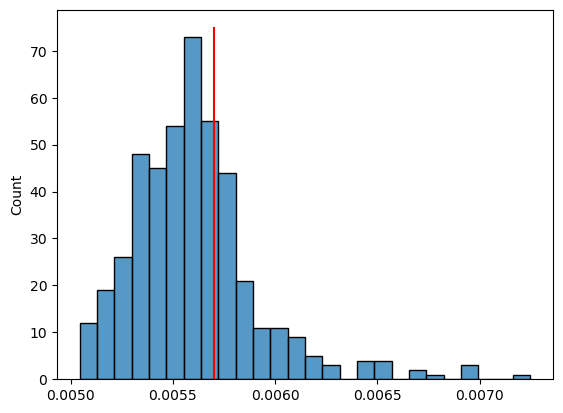

In [180]:
sns.histplot(initial_mtb_load_t0)
# plt.xlim(0.012, 0)
plt.vlines(np.mean(initial_mtb_load), 0, 75, colors='red')

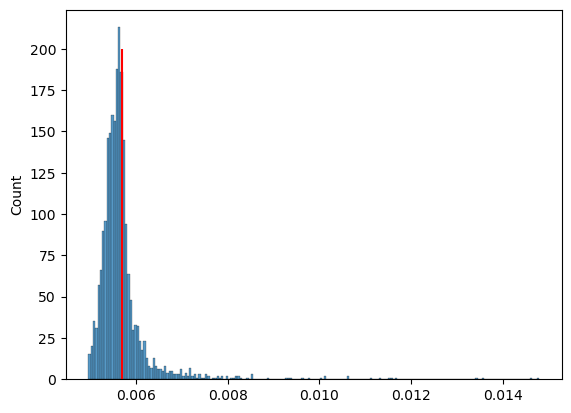

In [173]:
sns.histplot(initial_mtb_load)
# plt.xlim(0.012, 0)
plt.vlines(np.mean(initial_mtb_load), 0, 200, colors='red')

In [204]:
def add_scale(viewer, font_size = 24, text_colour = 'white', ticks = False, position = 'bottom_right'):
    """
    Params for adding a scale bar to napari.Viewer() 
    Actual scale must be defined in the viewer methods (i.e. viewer.add_image())
    """
    viewer.scale_bar.visible = True
    viewer.scale_bar.unit = 'm'
    viewer.scale_bar.font_size = font_size
    viewer.scale_bar.colored = True
    viewer.scale_bar.color = text_colour
    viewer.scale_bar.ticks = ticks
    viewer.scale_bar.position = position


In [224]:
def add_time(viewer, frame_rate = 1, font_size = 24, text_colour = 'white', position = 'bottom_left'):
    """
    Params for adding a time counter to napari.Viewer(). 
    Used in conju
    """
    def update_slider(event):
        # only trigger if update comes from first axis (optional)
        #ind_lambda = viewer.dims.indices[0]
        time = viewer.dims.current_step[0]
        viewer.text_overlay.text = f"{time:1.1f} hours"
    
    viewer.text_overlay.visible = True
    viewer.text_overlay.color = text_colour
    viewer.text_overlay.position = 'bottom_left'
    viewer.text_overlay.font_size = font_size
    viewer.dims.events.current_step.connect(update_slider)
    
    

In [ ]:
CTRL_tracks[0]

# Build plot

Need to create a function that extracts cell fate from obvious markers... does the cell leave the FOV? etc.

In [97]:
filt_CTRL_tracks[0]

,ID,t,x,y,z,parent,root,state,generation,dummy,minor_axis_length,major_axis_length,mean_intensity-0,mean_intensity-1,orientation,area
0,311,0,214.715118,649.776428,0.000000,311,311,5,0,False,67.977715,87.540939,0.019985,0.005709,-0.702612,4602.0
1,311,1,214.955872,648.901794,0.000000,311,311,5,0,False,59.075867,93.885040,0.023402,0.005699,-1.135783,4329.0
2,311,2,223.674240,650.713928,0.000000,311,311,5,0,False,63.196747,78.966621,0.031596,0.005765,-0.973927,3877.0
3,311,3,221.003372,652.696777,0.000000,311,311,5,0,False,68.969749,82.459908,0.020448,0.005688,-0.636698,4449.0
4,311,4,219.889526,644.160156,0.000000,311,311,5,0,False,70.720299,82.786476,0.017730,0.005681,-0.165750,4571.0
5,311,5,229.067581,637.181396,0.000000,311,311,5,0,False,71.674942,84.821068,0.019196,0.005696,-0.628409,4631.0
6,311,6,221.384613,636.014343,0.000000,311,311,5,0,False,77.587761,79.533455,0.014915,0.005663,-0.605209,4745.0
7,311,7,232.046127,633.646667,0.000000,311,311,5,0,False,75.166443,83.895653,0.015898,0.005669,-0.631393,4834.0
8,311,8,230.541687,633.444214,0.000000,311,311,5,0,False,69.983238,99.743805,0.014837,0.005657,-1.394356,5385.0
9,311,9,217.077103,637.043152,0.000000,311,311,5,0,False,72.682899,95.179710,0.012387,0.005652,-0.989412,5240.0


In [95]:
[len(track) for track in filt_CTRL_tracks]

[75,
 11,
 12,
 30,
 75,
 10,
 4,
 75,
 73,
 29,
 34,
 5,
 44,
 29,
 9,
 64,
 4,
 75,
 37,
 12,
 28,
 5,
 6,
 67,
 57,
 12,
 10,
 75,
 26,
 75,
 75,
 7,
 23,
 9,
 75,
 75,
 8,
 6,
 73,
 8,
 75,
 10,
 75,
 13,
 31,
 64,
 42,
 6,
 75,
 9,
 18,
 65,
 50,
 75,
 22,
 62,
 12,
 21,
 10,
 9,
 49,
 23,
 9,
 4,
 75,
 75,
 30,
 75,
 54,
 41,
 75,
 75,
 11,
 75,
 24,
 32,
 46,
 7,
 14,
 75,
 75,
 12,
 5,
 5,
 30,
 6,
 6,
 9,
 73,
 4,
 5,
 4,
 75,
 75,
 75,
 75,
 5,
 5,
 75,
 9,
 4,
 73,
 4,
 75,
 36,
 74,
 8,
 31,
 42,
 19,
 15,
 54,
 5,
 75,
 28,
 64,
 12,
 18,
 14,
 4,
 15,
 74,
 8,
 70,
 10,
 5,
 69,
 25,
 4,
 21,
 14,
 29,
 9,
 21,
 10,
 26,
 10,
 75,
 20,
 75,
 65,
 11,
 33,
 75,
 46,
 41,
 75,
 75,
 75,
 69,
 39,
 7,
 75,
 18,
 53,
 75,
 75,
 4,
 75,
 16,
 7,
 37,
 14,
 75,
 33,
 7,
 12,
 6,
 7,
 42,
 4,
 75,
 14,
 8,
 6,
 39,
 75,
 40,
 10,
 7,
 5,
 31,
 75,
 74,
 5,
 13,
 60,
 73,
 43,
 17,
 18,
 12,
 75,
 75,
 72,
 5,
 12,
 75,
 12,
 4,
 13,
 12,
 22,
 75,
 75,
 5,
 10,
 50,
 69,
 15,
 7